# Data storytelling 

The dataset we will use is the result of a campaign of measure where the data are colected during the experiment. <br>
The circuit simulates an hypdoponic system and we are studying the pump in the circuit. <br> Different parameter are measured: <br>
- The current consumed by the pump
- The flow in the circuit
- The position of the valve before the pump simulating a filter clogging process
- The position of the valve after the pump simulating the load of the hydroponic circuit
- The velocity of the pump corresponding to the command on the box controlling the velocity of the pump
<br>
The code here after populates a pandas dataframe with the data of the csv file captured with the campaign of measure.
Measures are converted in physical value to allow a simpler interpretation<br>
The experiment is executed with different cycle and for each of cycle the velocity of the pump and the output load (valve after the pump position) remain constant. We have 11 cycles as you will observe in the graphic.<br><br>
Each cycle is composed by two phases: <br>
- The phase starting by a valve closed to a completly open position of the valve (opening phase)
- The phase starting by a completly open position to a closed position (closing phase)

In [1]:
import pandas as pd
import numpy as np

def load_acquisition_data(filelocation):
    format = '%Y-%m-%d %H:%M:%S,%f'
    df =pd.read_csv(filelocation, sep=';',parse_dates=True);
    times = pd.to_datetime(df.DateTime , format=format)
    df.set_index(times, inplace=True)
    df['ValveOpening'] = df['EntryLoad'] - df['EntryLoad'].shift(-1) <0
    return df

pumpdata = load_acquisition_data('..\data\PumpMeasuresFormated.csv')
pumpdata["Flow"]=(pumpdata["Flow"]/97)*360
pumpdata["PumpCurrent"] = ((pumpdata["PumpCurrent"]/4095)*2.44 +3.85)/(11.8*0.5)
pumpdata["EntryLoad"]= pumpdata["EntryLoad"]/255*100

The value measured of the current is obtained in labjack U3 via an analog to numeric converter with 12 bits precision <br>
An amplifier operational with a gain and an offset is used to convert the measure of the voltage on the shunt to
a voltage varying form 0 to 2.44 volt <br>
The amplifier operational function transfert is a linear function with a gain of 11.8 and an offset of -3.85 and the shunt resistor value is 0.5 ohm <br>
The formula in the code transforms the numeric value returned by the CAN to the intensity consumed by the pump <br> <br>
The flow meter provides 97 pulses for each litter and the flow measure period is 10s <br>
The flow in l/h is obtained by (Nbpulse/97)*360<br>
<br>
The valve representing the filter (entry load) is controled via a voltage from 0 to 10V and controlled via a numeric to analog converter of 8 bits. So the value of the entry vary from 0 to 255 and we translate from 0 to 100.<br><br>
<b>This dataset contains 1980 measures</b>


In [2]:
pumpdata.head()

,Id,Cycle,DateTime,Flow,EntryLoad,OutputLoad,PumpCurrent,PumpVelocity,ValveOpening
DateTime,,,,,,,,,
2017-04-23 14:38:39.310,0,1,"2017-04-23 14:38:39,310",360.00000,100.000000,100,1.029644,10,False
2017-04-23 14:38:52.515,1,1,"2017-04-23 14:38:52,515",352.57732,98.039216,100,1.049539,10,False
2017-04-23 14:39:05.554,2,1,"2017-04-23 14:39:05,554",356.28866,96.078431,100,1.094682,10,False
2017-04-23 14:39:18.585,3,1,"2017-04-23 14:39:18,585",363.71134,94.117647,100,1.024190,10,False
2017-04-23 14:39:31.616,4,1,"2017-04-23 14:39:31,616",363.71134,92.156863,100,1.096399,10,False


In [3]:
pumpdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1980 entries, 2017-04-23 14:38:39.310000 to 2017-04-23 22:51:14.356000
Data columns (total 9 columns):
Id              1980 non-null int64
Cycle           1980 non-null int64
DateTime        1980 non-null object
Flow            1980 non-null float64
EntryLoad       1980 non-null float64
OutputLoad      1980 non-null int64
PumpCurrent     1980 non-null float64
PumpVelocity    1980 non-null int64
ValveOpening    1980 non-null bool
dtypes: bool(1), float64(3), int64(4), object(1)
memory usage: 141.2+ KB


In [4]:
pumpdata.describe()

,Id,Cycle,Flow,EntryLoad,OutputLoad,PumpCurrent,PumpVelocity
count,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000
mean,989.500000,6.000000,212.835989,49.860566,77.272727,0.920341,7.727273
std,571.721086,3.163077,80.971236,29.117532,24.902769,0.098030,1.601024
min,0.000000,1.000000,0.000000,0.000000,50.000000,0.741213,5.000000
25%,494.750000,3.000000,152.164948,24.901961,50.000000,0.842810,6.000000
50%,989.500000,6.000000,233.814433,49.803922,100.000000,0.928047,8.000000
75%,1484.250000,9.000000,267.216495,74.705882,100.000000,0.997983,9.000000
max,1979.000000,11.000000,382.268041,100.000000,100.000000,1.101348,10.000000


For the current consumed by the pump we can observe the current variation is from 0.74A to 1.10A<br>
The flow variation is from 0 l/h to 382 l/h approximatively<br>
The entry load vary from 0 to 100 and correspond to the command sent to the motorised valve

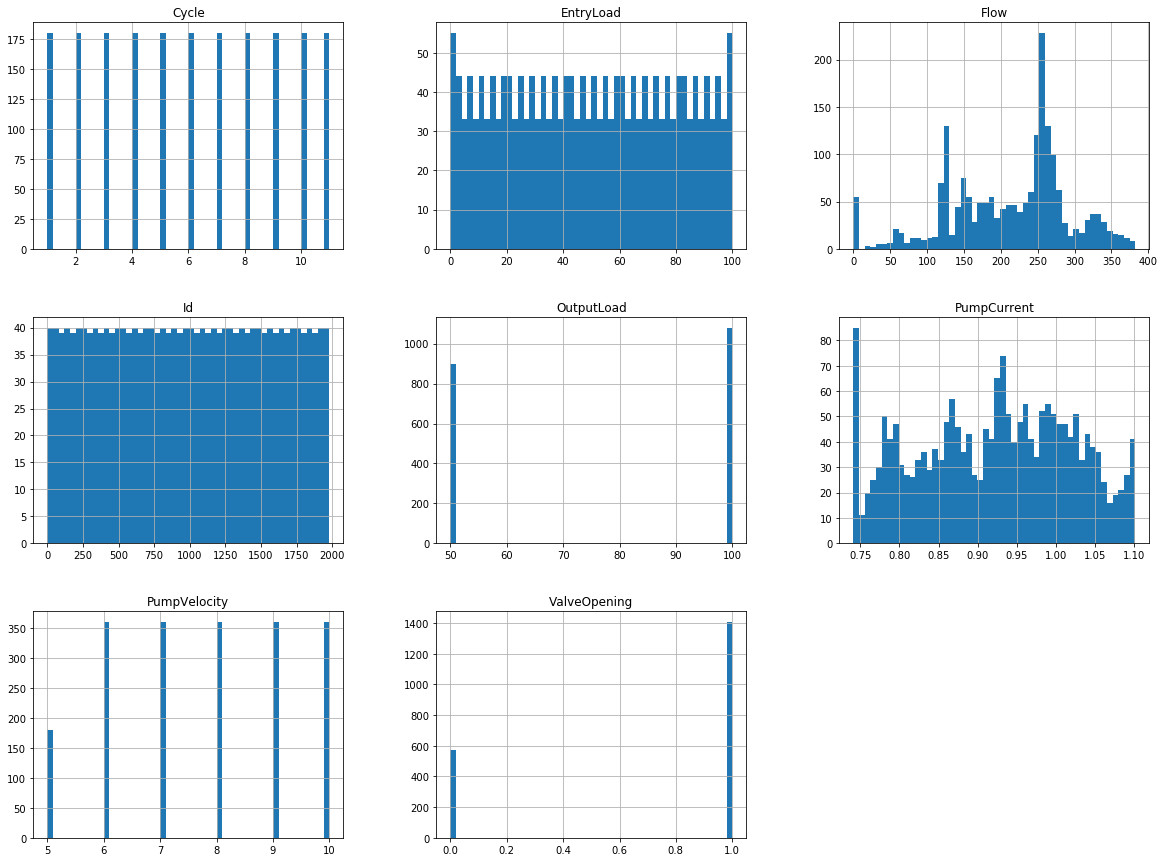

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
subset = pumpdata
subset.hist(bins=50, figsize=(20,15))
plt.show()

In the histogram matrix here above we can discover the parameter controlling the measure. On the first line on the left you can observe the 11 cycles with the same number of measure captured for each cycle. <br> <br>For the pump velocity, the measure is done with velocity varying from the position 10 to the position 5. <br>For the position 5 we have the half of the measure compared to the other velocity because the velocity 5 is used only in combinaison with the output load à 100%. For the output load we see two modes, one for the first half of the cycle executed with an output load at 100% and you have the second group of the cycles realized at 50% of the output load.<br> <br>
For the valve opening histogram indicating the part of the cycle, we have appriximaticely 600 measures done during the closing phase and 1400 done durring the opening phase. This ratio is explained by the step value used to control the valve:<br>
- For the closing phase the value decrease by 5
- For the opening phase the value increase by 2

So the ratio is 2/5  and graphically we can see the ratio is 6/14<br>

For the entry load histogram the value maximum are for 0 and 255 because these values are used for the opening and closing phase. The variation observed for the other value correspond to the common value for the variation by 5 and the variation by 2. This explains the crenel shape of the histogram.<br><br>
For the current and the flow the histogram are more complex to explain. <br><b>An hypothesis is that each pic correspond to the differents cycle with different parameters (velocity, entry load, output load)</b><br><br>
Because the dataset is not big we can build the correletion matrix corresponding to this dataset and observ how the different features are related. 

In [6]:
corrMatrix = pumpdata.corr()
corrMatrix["Flow"].sort_values(ascending=False)

Flow            1.000000
PumpCurrent     0.528724
EntryLoad       0.469189
OutputLoad      0.426974
PumpVelocity    0.420789
ValveOpening   -0.135560
Id             -0.601973
Cycle          -0.616372
Name: Flow, dtype: float64

The variation of the flow is explained by :
- the variation of the current 0.53
- the entryload 0.47
- the outputload 0.46
- the pump velocity 0.42

We can say with these values, the flow could be explained by the current measured

In [7]:
corrMatrix = pumpdata.corr()
corrMatrix["PumpCurrent"].sort_values(ascending=False)

PumpCurrent     1.000000
PumpVelocity    0.860930
Flow            0.528724
EntryLoad       0.105407
OutputLoad      0.086678
ValveOpening   -0.017460
Id             -0.512428
Cycle          -0.517659
Name: PumpCurrent, dtype: float64

The variation of the current is explained by :
- the variation of the velocity 0.86
- the flow 0.53
- the entry load 0.1
- the output load 0.08

We  can say with this values, the flow could be explained by the velocity of the pump and the flow. The entry load and the output load have a slow impact.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000009BFA6E82B0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000009BF970BF60>]], dtype=object)

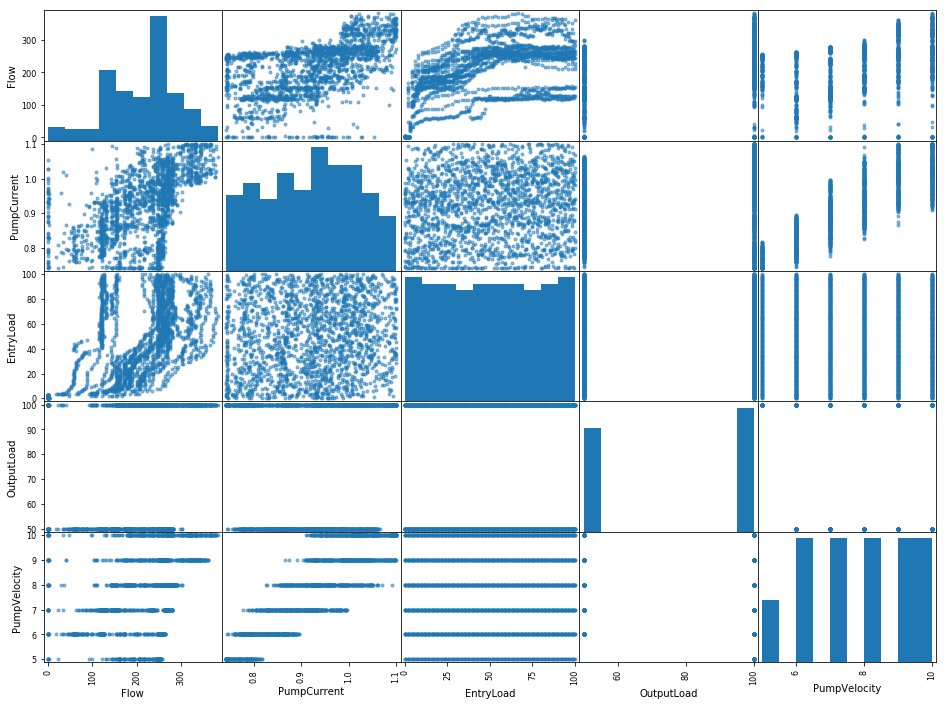

In [8]:
from pandas.tools.plotting import scatter_matrix
attributes = ["Flow","PumpCurrent","EntryLoad","OutputLoad","PumpVelocity"]
scatter_matrix(pumpdata[attributes],figsize=(16,12))

The scatter matrix here above allow to confirm the observation done with the correlation matrix.<br>
The curve observed for the relation between entry load and flow confirm a correlation exists between these two features.<br>
The scatter plot representing the relation between entryload and pump current show a cloud of point but no curve clearly appears. No clear correlation exists between the current and the entry load<br>
A relation exists between flow and pump current but the scatter plot representing the relation between flow and pump velocity show the range of flow changes in function of the velocity of the pump. We have the same behaviour between the pump current and the velocity of the pump.<br>
The scatter plot between the output load and the pump velocity shows the 11 cycle corresponding to the combinaison of these two parameters.

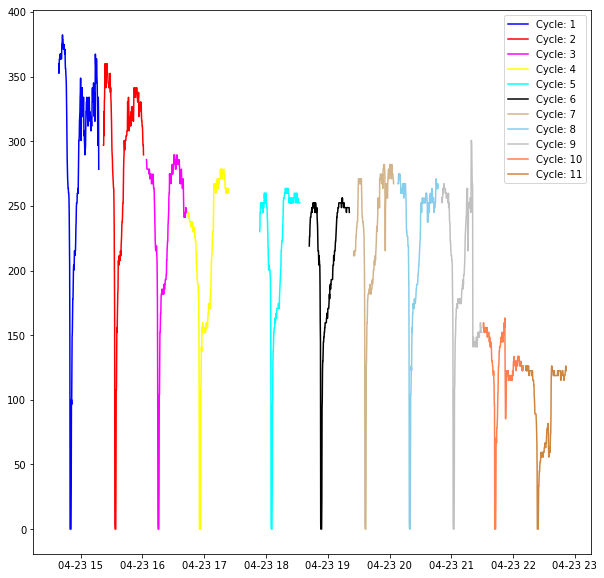

In [9]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    cyclename = 'Cycle: ' + str(cycle)
    plt.plot_date(subset.DateTime, subset.Flow,'b-', c=colors[cycle-1], label=cyclename)
plt.legend()

The graphic here above show for each cycle how the flow vary with the time. We can see for each cycle the two phases (closing and opening) of the valve.<br> We can see the experiment was done the 23 Apil 2017 between 15:00 and 23:00.<br> All the cycle have approximatively the same shape except for the cycle 9.

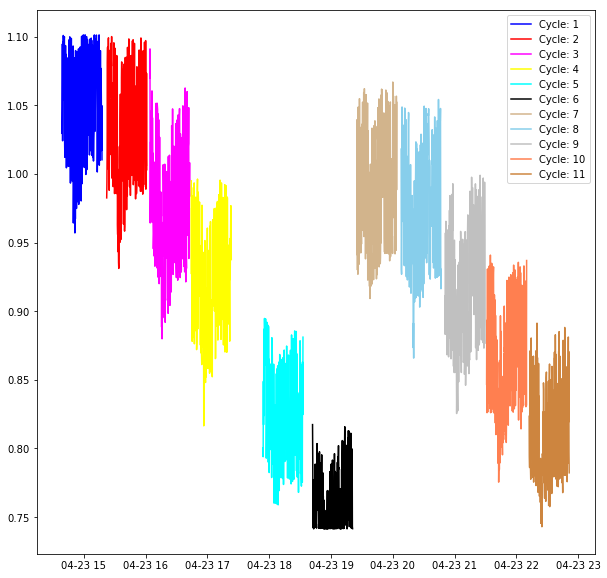

In [10]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    cyclename = 'Cycle: ' + str(cycle)
    plt.plot_date(subset.DateTime, subset.PumpCurrent,'b-', c=colors[cycle-1], label=cyclename)
plt.legend()

This graphic shows the variation of the current for each cycle. We can see the range of the current change for each cycle and <b> an important noise </b> seems attached to this feature. This noise could explain we can't see a clear relation between the current and the entry load or between the current and the flow.

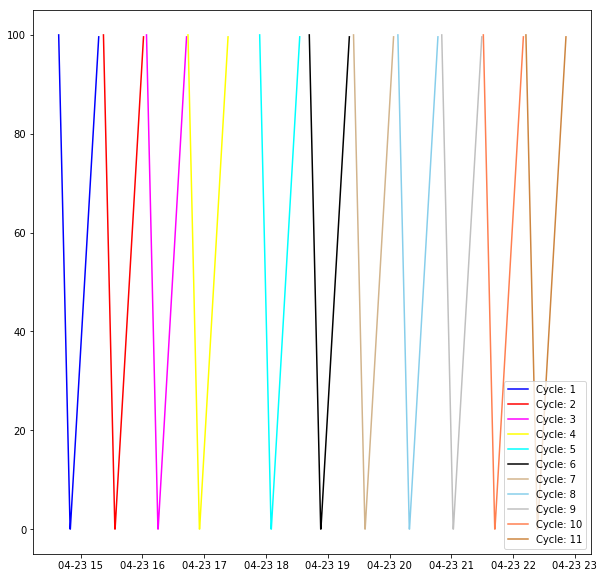

In [11]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    cyclename = 'Cycle: ' + str(cycle)
    plt.plot_date(subset.DateTime, subset.EntryLoad,'b-', c=colors[cycle-1], label=cyclename)
plt.legend()

This graphic shows the variation of the entry load for each cycle. We can see for each cycle the two phases.<br> The slope of the curve is most important for the closing phase of the cycle because the value decrease by 5 and for the opening phase the value increase by 2. The variation is between 0 and 100.

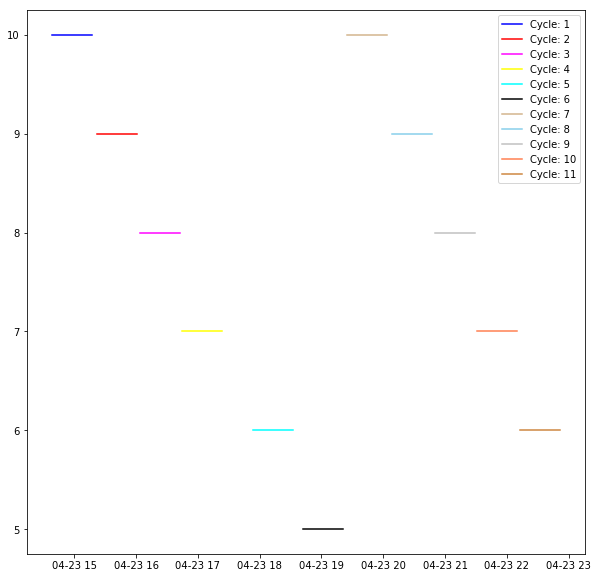

In [26]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    cyclename = 'Cycle: ' + str(cycle)
    plt.plot_date(subset.DateTime, subset.PumpVelocity,'b-', c=colors[cycle-1], label=cyclename)
plt.legend()

We can see in the graphic above the variation of the velocity of the pump for each cycle. The velocity 5 is used only for one cycle for the output load at 100%. The remaining velocity (10,9,8,7,6) are used for the two output load.

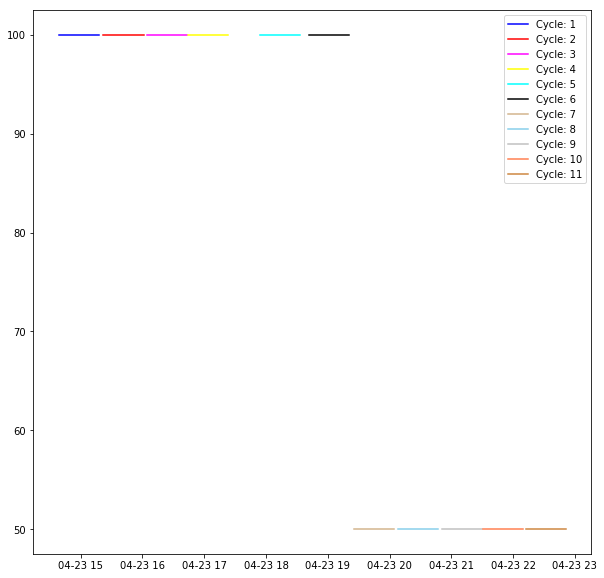

In [12]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    cyclename = 'Cycle: ' + str(cycle)
    plt.plot_date(subset.DateTime, subset.OutputLoad,'b-', c=colors[cycle-1], label=cyclename)
plt.legend()

The graphic above shows the variation of the output load for each cycle. We can see that the 6 first cycle are done with an output load at 100% and the 5 remaining cycle with an output load at 50%.

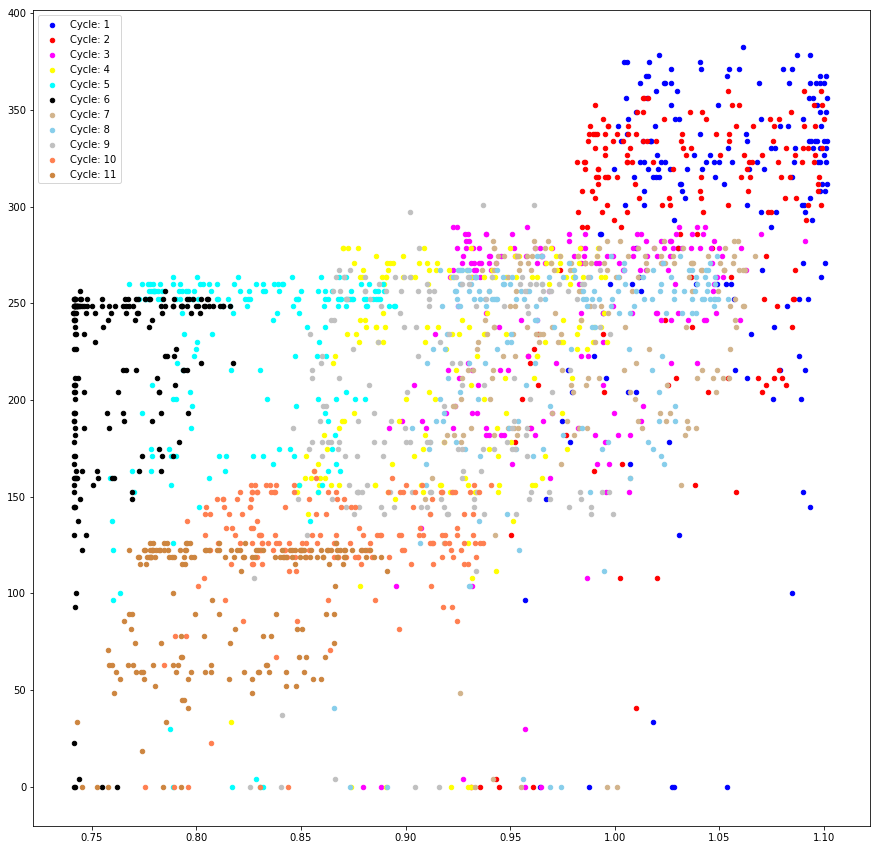

In [13]:
plt.figure(figsize=(15,15))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    cyclename = 'Cycle: ' + str(cycle)
    plt.scatter(subset.PumpCurrent, subset.Flow,s=20, c=colors[cycle-1], label=cyclename)
plt.legend()

The graphic above show the relation between the flow and the current consumed by the pump. We can see the flow max change for each cycle and the range of the current change for each cycle too. <br><b>Because the current measured contains lot off noise we can't see a curve showing this relation.</b>

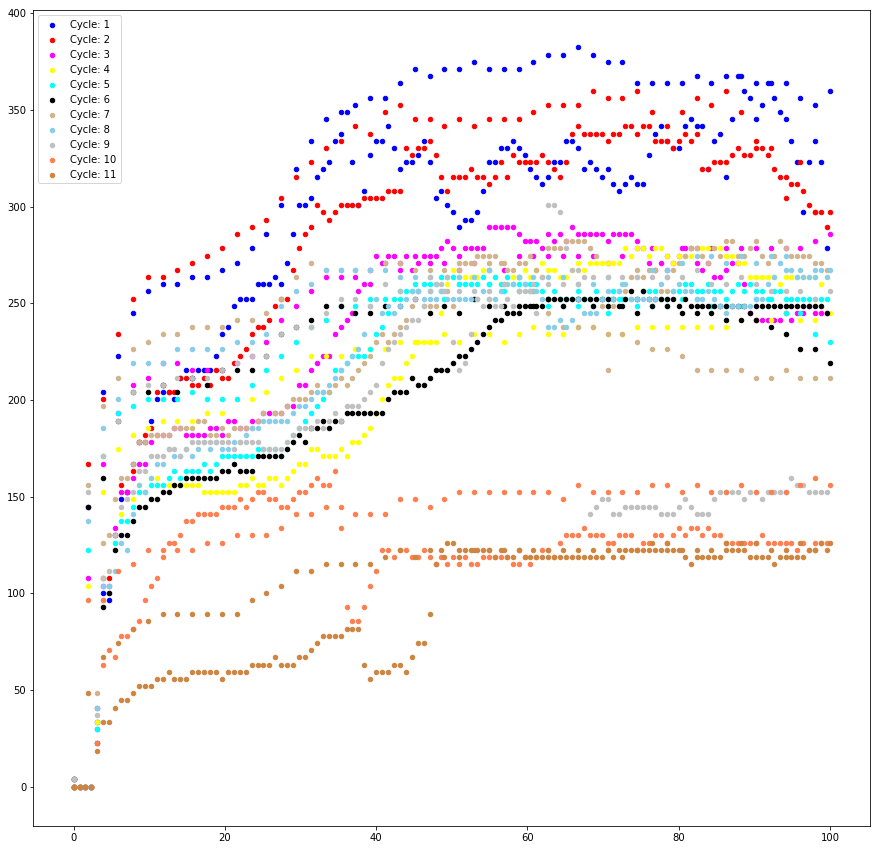

In [14]:
plt.figure(figsize=(15,15))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    cyclename = 'Cycle: ' + str(cycle)
    plt.scatter(subset.EntryLoad, subset.Flow, s=20, c=colors[cycle-1], label=cyclename)
plt.legend()

The graphic above shows the relation between the entry load and the flow. We can see clearly the curve for each cycle.<br> For each cycle we can see two curves. One curve representing the closing phase of the valve and one curve representing the opening phase of the cycle.

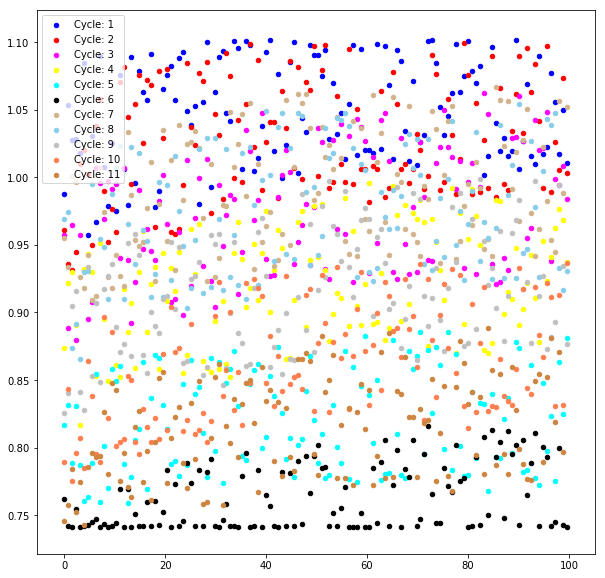

In [15]:
plt.figure(figsize=(10,10))
for cycle in range(1,12):
    colors = ['blue','red','magenta','yellow','cyan','black','tan','skyblue','silver','coral','peru']
    subset = pumpdata[pumpdata.Cycle==cycle].dropna()
    subset = subset[subset.ValveOpening==True]
    cyclename = 'Cycle: ' + str(cycle)
    plt.scatter(subset.EntryLoad, subset.PumpCurrent, s=20, c=colors[cycle-1], label=cyclename)
plt.legend()

The scatter plot above shows the relation betwin the current consumed by the pump and the entry load. We don't see a curve but we can see the current remains in a range of value for each cycle. Because the current measured contains lot off noise it's difficult to define if a relation exists between current and entry load. The correlation coefficient between current and entry load is only 0.1.

# Conclusion

The graphics above shows a relation exists betweeen the entry load and the flow. For the current it's not the same because we don't see a clear curve between current and flow or current and entry load. We can see the source of this difficulty to observe a correlation with the current comes from the noise contained in the measure. In the next step of the project we will use tools to clean the noise contained in the current and observe again the correlation with the current. In this project we would measure the current and predict the filter clogging. At this stage of the project it's difficult to say if it will be possible.